In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torchvision import datasets, transforms, utils
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
jupyter.textOutputLimit = 0

In [2]:
# Initialization
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
EPOCHS = 300
BATCH_SIZE = 2500

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout_p = dropout_p
    def forward(self, x):
        x = x.view(x.size(0), 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=self.dropout_p)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training, p=self.dropout_p)
        x = self.fc3(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss 

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        #if batch_idx % 2 == 0:
        #    print('[{}] [{}/{} ({:.0f}%)]\tTrain Loss: {:.4f}'.format(epoch, batch_idx*len(data), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))
    
    train_loss /= len(train_loader.dataset)/BATCH_SIZE
    train_loss = train_loss.cpu()
    train_loss = train_loss.detach().numpy()
    train_accuracy = 100.*correct / len(train_loader.dataset)
    print('[{}] Train Loss: {:.4f}, Train Accuracy: {:.2f}%'.format(epoch, train_loss, train_accuracy))
    return train_loss, train_accuracy
def evaluate(mdoel, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct / len(test_loader.dataset)
    print('[{}] Test Loss: {:.4f}, Test Accuracy: {:.2f}%\n'.format(epoch, test_loss, test_accuracy))
    return test_loss, test_accuracy

In [5]:
trainset = datasets.CIFAR10(
    root      = './data/',
    train     = True,
    download  = True,
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), 
                             (0.5, 0.5, 0.5))
    ])
)
testset = datasets.CIFAR10(
    root      = './data/',
    train     = False,
    download  = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), 
                             (0.5, 0.5, 0.5))
    ])
)

train_loader = data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)
test_loader = data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
model = ResNet().to(DEVICE)
#optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
print(model)
history = dict()
history['loss'] = []
history['acc'] = []
history['val_loss'] = []
history['val_acc'] = []
for epoch in range(1, EPOCHS+1):
    loss, accuracy = train(model, train_loader, optimizer)
    scheduler.step()
    test_loss, test_accuracy = evaluate(model, test_loader)
    history['loss'].append(loss)
    history['acc'].append(accuracy)
    history['val_loss'].append(test_loss)
    history['val_acc'].append(test_accuracy)

698, Test Accuracy: 87.18%

[95] Train Loss: 0.1358, Train Accuracy: 95.29%
[95] Test Loss: 0.4609, Test Accuracy: 87.29%

[96] Train Loss: 0.1305, Train Accuracy: 95.51%
[96] Test Loss: 0.4682, Test Accuracy: 87.15%

[97] Train Loss: 0.1334, Train Accuracy: 95.41%
[97] Test Loss: 0.4681, Test Accuracy: 86.94%

[98] Train Loss: 0.1312, Train Accuracy: 95.40%
[98] Test Loss: 0.4546, Test Accuracy: 87.31%

[99] Train Loss: 0.1305, Train Accuracy: 95.45%
[99] Test Loss: 0.4665, Test Accuracy: 87.44%

[100] Train Loss: 0.1323, Train Accuracy: 95.45%
[100] Test Loss: 0.4587, Test Accuracy: 87.57%

[101] Train Loss: 0.1266, Train Accuracy: 95.71%
[101] Test Loss: 0.4534, Test Accuracy: 87.53%

[102] Train Loss: 0.1243, Train Accuracy: 95.79%
[102] Test Loss: 0.4525, Test Accuracy: 87.44%

[103] Train Loss: 0.1231, Train Accuracy: 95.74%
[103] Test Loss: 0.4509, Test Accuracy: 87.56%

[104] Train Loss: 0.1222, Train Accuracy: 95.74%
[104] Test Loss: 0.4516, Test Accuracy: 87.60%

[105] Train 

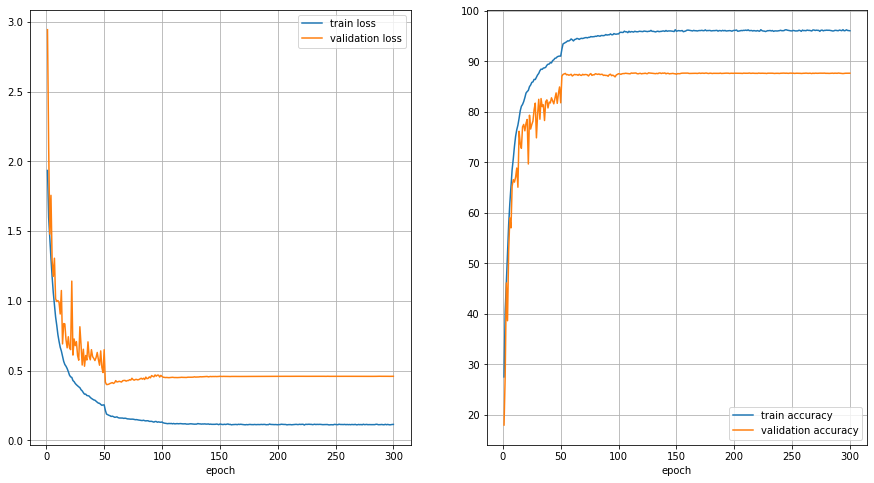

In [7]:
epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="validation loss")
plt.xlabel("epoch")
plt.legend(loc='best')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(epochs, history['acc'], label="train accuracy")
plt.plot(epochs, history['val_acc'], label="validation accuracy")
plt.xlabel("epoch")
plt.legend(loc='best')
plt.grid(True)
plt.show()